In [129]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Read data
## Grouping M&A volume by month

In [130]:
def reconfigure_vol_df(df):
    df['Date'] = df['Date'].dt.to_period('M')
    out = {'date': [], 'vol': []}
    for y in range(2000, 2022):
        for m in range(1, 13):
            i = f"{y}-{m}"
            d = df[df['Date'] == i]
            out['date'].append(i)
            out['vol'].append(len(d))
    df = pd.DataFrame(data=out['vol'], index=out['date'], columns=['vol'])
    df.index.name = 'date'
    return df

In [131]:
"""Groups M&A transactions of UK being the acquirer by month"""
acquirer_uk = read_acquirer_uk()
acquirer_uk = reconfigure_vol_df(acquirer_uk)

In [132]:
"""Groups M&A transactions of UK being the target by month"""
target_uk= read_target_uk()
target_uk = reconfigure_vol_df(target_uk)

In [133]:
"""Net M&A volume"""
net_vol_monthly = target_uk - acquirer_uk

In [134]:
# net_vol_monthly.index.values.astype(str)

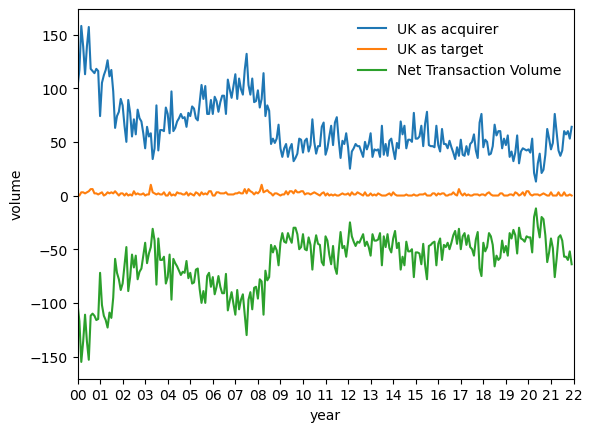

In [135]:
ax = plt.gca()
ax.plot(acquirer_uk.index.values.astype(str), acquirer_uk.vol, label='UK as acquirer')
ax.plot(target_uk.index.values.astype(str), target_uk.vol, label='UK as target')
ax.plot(net_vol_monthly.index.values.astype(str), net_vol_monthly.vol, label='Net Transaction Volume')
ax.set_xticks([])
ax.legend(frameon=False)
ax.set_xticks(ticks=range(0, 265, 12), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 264)
ax.set_ylabel('volume')
ax.set_xlabel('year');

## GDP

## Only quarterly data available

In [136]:
gdp_quarter = read_gdp()
until = '2022-01'
gdp_quarter['Date'] = gdp_quarter['Date'].dt.to_period('M')
gdp_quarter = gdp_quarter[gdp_quarter['Date'] < until]
# gdp_quarter

In [137]:
"""Regrouping transactions by cumulative of 3 months and quarterly data of other explanatory variables: SMI, EXUSUK, and SMI."""
res = []
for i in range(int(len(net_vol_monthly)/3)):
    s = net_vol_monthly[3*i: 3*(i+1)]
    res.append(s.vol.sum())
gdp_quarter['vol'] = res
# gdp_quarter

## Variables

In [138]:
until = '2022-01'
var_monthly = read_variable_monthly()
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())
gdp_quarter['EXUSUK'] = res['EXUSUK']
gdp_quarter['Interest_Rate'] = res['Interest_Rate']
gdp_quarter['SMI'] = res['SMI']
# gdp_quarter

# Regression

In [139]:
"""To determine the effect the Brexit, we refer to the day of UK announcing its plan to exit the European Union as the separation date"""

x_index = ['EXUSUK', 'Interest_Rate', 'SMI', 'UK_GDP']
y_index = ['vol']

data = gdp_quarter
sep = '2016-6'
data_before = gdp_quarter[gdp_quarter.Date < sep]
data_after = gdp_quarter[gdp_quarter.Date > sep]

"""Regressing on historical transactions between Jan.2000 to June.2016"""
X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_train = sm.add_constant(X_train)

"""Regressing on historical transactions between June.2016 to Nov.2021"""
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)
X_test = sm.add_constant(X_test)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

"""R square of model before and after the announcement of Brexit"""
model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)


(0.8851251252423746, 0.4834364945013142)

In [140]:
model_before.coef_

array([[ 0.00000000e+00,  1.53951589e+02, -2.52998083e+01,
        -2.00656937e-01,  5.73159151e-04]])

In [141]:
model_before.intercept_

array([-421.25353794])

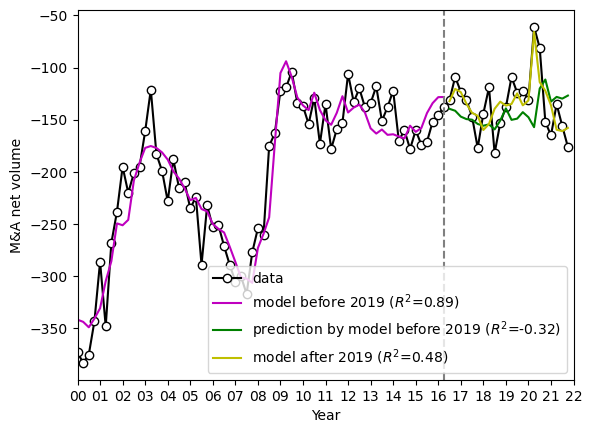

In [142]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2019 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2019 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2019 ($R^2$={round(r, 2)})')

ax.axvline(65, ls='--', color='gray')
plt.xticks(ticks=range(0, 89, 4), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 88)
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
# ax.set_ylim(0, -500)
ax.legend(loc=0, frameon=True);

## Model before announcement of Brexit

In [167]:
"""Summary of model based on historical data before 2016"""
multi_model_before = sm.OLS(Y_train, X_train).fit()
X_train
multi_model_before.summary()
# """[X1:'EXUSUK', X2:'Interest_Rate', X3:'SMI', X4:'UK_GDP']"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     117.5
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           6.08e-28
Time:                        16:16:33   Log-Likelihood:                -304.92
No. Observations:                  66   AIC:                             619.8
Df Residuals:                      61   BIC:                             630.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -421.2535     80.401     -5.239      0.000    -582.025    -260.482
x1           153.9516     28.158      5.467      0.000      97.646     210.257
x2           -25.2998      3.044     -8.312      0.000     -31.386     -19.213
x3            -0.2007      0.024     -8.284      0.000      -0.249      -0.152
x4             0.0006      0.000      2.688      0.009       0.000       0.001
==============================================================================
Omnibus:                        3.731   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                2.998
Skew:                           0.507   Prob(JB):                        0.223
Kurtosis:                       3.249   Cond. No.                     1.19e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


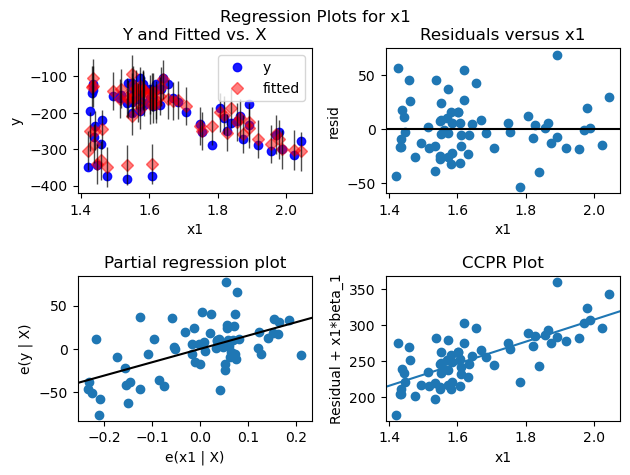

In [144]:
fig_before1 = sm.graphics.plot_regress_exog(multi_model_before, 1)

eval_env: 1


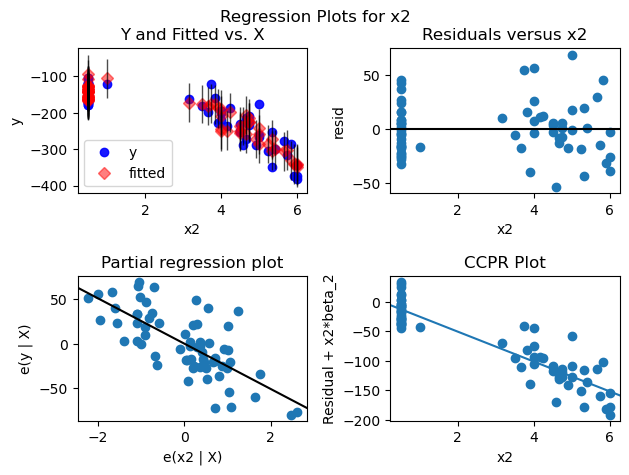

In [145]:
fig_before2 = sm.graphics.plot_regress_exog(multi_model_before, 2)

eval_env: 1


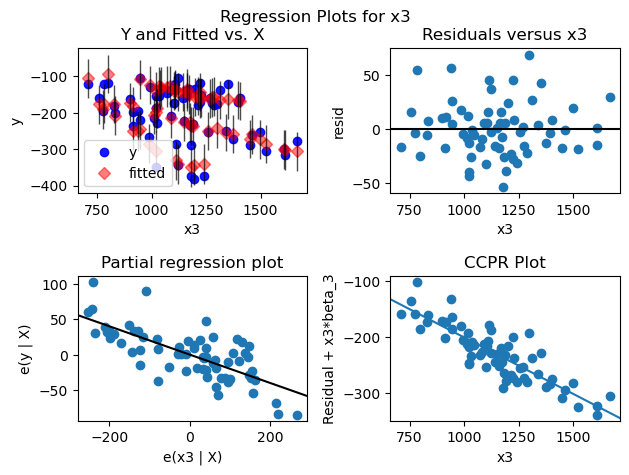

In [146]:
fig_before3 = sm.graphics.plot_regress_exog(multi_model_before, 3)

eval_env: 1


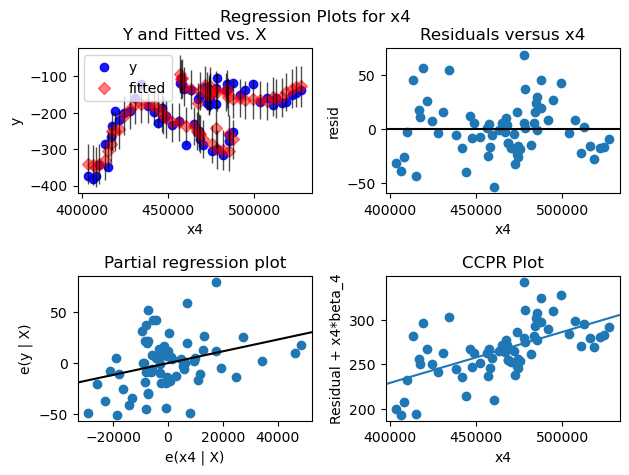

In [147]:
fig_before4 = sm.graphics.plot_regress_exog(multi_model_before, 4)

In [148]:
print(multi_model_before.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI', 'UK_GDP']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     117.5
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           6.08e-28
Time:                        16:15:46   Log-Likelihood:                -304.92
No. Observations:                  66   AIC:                             619.8
Df Residuals:                      61   BIC:                             630.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -421.2535     80.401     -5.239      0.0

In [149]:
sm.add_constant(X_train)

array([[1.00000000e+00, 1.60676667e+00, 5.91666667e+00, 1.24194800e+03,
        4.03407000e+05],
       [1.00000000e+00, 1.53350000e+00, 6.00000000e+00, 1.19300400e+03,
        4.06049000e+05],
       [1.00000000e+00, 1.47670000e+00, 6.00000000e+00, 1.18140433e+03,
        4.08120000e+05],
       [1.00000000e+00, 1.44643333e+00, 6.00000000e+00, 1.12138800e+03,
        4.09871000e+05],
       [1.00000000e+00, 1.45816667e+00, 5.83333333e+00, 1.11246033e+03,
        4.13381000e+05],
       [1.00000000e+00, 1.42110000e+00, 5.33333333e+00, 1.02155933e+03,
        4.14894000e+05],
       [1.00000000e+00, 1.43860000e+00, 5.00000000e+00, 9.87710667e+02,
        4.16803000e+05],
       [1.00000000e+00, 1.44233333e+00, 4.16666667e+00, 9.16732667e+02,
        4.17480000e+05],
       [1.00000000e+00, 1.42596667e+00, 4.00000000e+00, 9.38210000e+02,
        4.18930000e+05],
       [1.00000000e+00, 1.46213333e+00, 4.00000000e+00, 9.46377667e+02,
        4.21133000e+05],
       [1.00000000e+00, 1.5498

In [150]:
multi_model_before.model.exog

array([[1.00000000e+00, 1.60676667e+00, 5.91666667e+00, 1.24194800e+03,
        4.03407000e+05],
       [1.00000000e+00, 1.53350000e+00, 6.00000000e+00, 1.19300400e+03,
        4.06049000e+05],
       [1.00000000e+00, 1.47670000e+00, 6.00000000e+00, 1.18140433e+03,
        4.08120000e+05],
       [1.00000000e+00, 1.44643333e+00, 6.00000000e+00, 1.12138800e+03,
        4.09871000e+05],
       [1.00000000e+00, 1.45816667e+00, 5.83333333e+00, 1.11246033e+03,
        4.13381000e+05],
       [1.00000000e+00, 1.42110000e+00, 5.33333333e+00, 1.02155933e+03,
        4.14894000e+05],
       [1.00000000e+00, 1.43860000e+00, 5.00000000e+00, 9.87710667e+02,
        4.16803000e+05],
       [1.00000000e+00, 1.44233333e+00, 4.16666667e+00, 9.16732667e+02,
        4.17480000e+05],
       [1.00000000e+00, 1.42596667e+00, 4.00000000e+00, 9.38210000e+02,
        4.18930000e+05],
       [1.00000000e+00, 1.46213333e+00, 4.00000000e+00, 9.46377667e+02,
        4.21133000e+05],
       [1.00000000e+00, 1.5498

In [151]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.621984421897367),
 ('p-value', 0.45957428291042113),
 ('f-value', 0.8854924595152533),
 ('f p-value', 0.47808004872445076)]

In [152]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,5)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

,VIF
UK_GDP,2.308467
EXUSUK,4.435098
Interest_Rate,2.675092
SMI,4.649567


## Model after announcement of Brexit

In [153]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     3.977
Date:                Tue, 22 Nov 2022   Prob (F-statistic):             0.0186
Time:                        16:15:46   Log-Likelihood:                -97.924
No. Observations:                  22   AIC:                             205.8
Df Residuals:                      17   BIC:                             211.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        426.8467    186.813      2.285      0.035      32.705     820.989
x1          -200.0124    137.158     -1.458      0.163    -489.391      89.366
x2            19.6496     29.151      0.674      0.509     -41.853      81.152
x3            -0.0378      0.101     -0.373      0.714      -0.252       0.176
x4            -0.0005      0.000     -1.468      0.160      -0.001       0.000
==============================================================================
Omnibus:                        0.557   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.650
Skew:                          -0.265   Prob(JB):                        0.722
Kurtosis:                       2.346   Cond. No.                     2.34e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name_after, test_after)

[('Lagrange multiplier statistic', 3.621984421897367),
 ('p-value', 0.45957428291042113),
 ('f-value', 0.8854924595152533),
 ('f p-value', 0.47808004872445076)]

In [155]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,5)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

,VIF
UK_GDP,1.775838
EXUSUK,2.156643
Interest_Rate,3.698234
SMI,3.596139


eval_env: 1


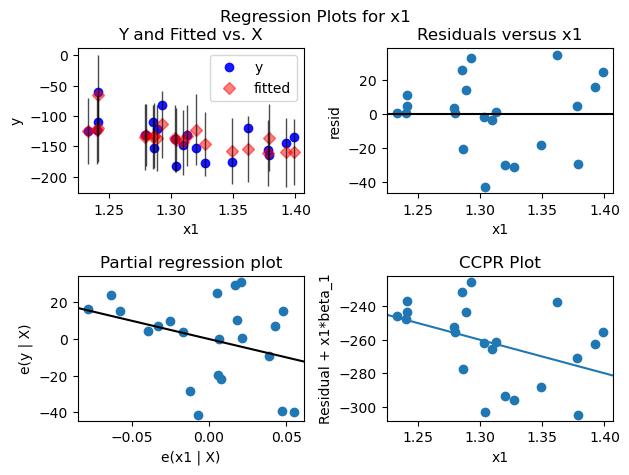

In [156]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

eval_env: 1


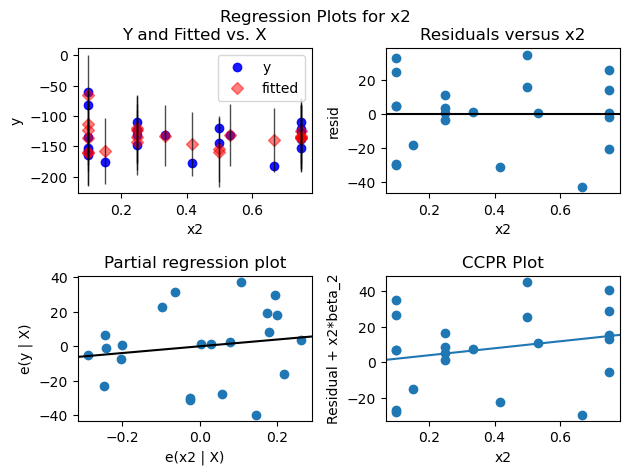

In [157]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

eval_env: 1


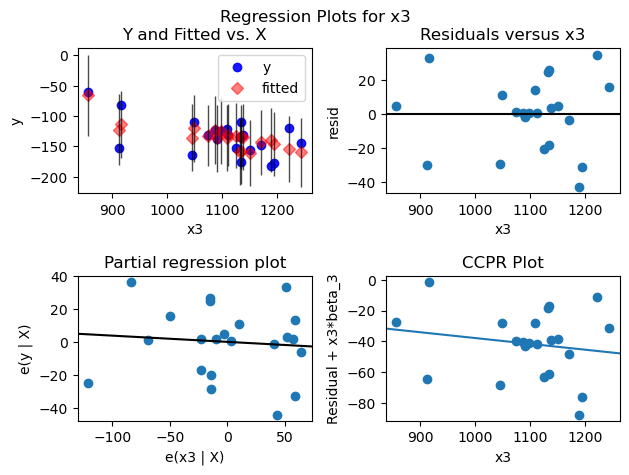

In [158]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

eval_env: 1


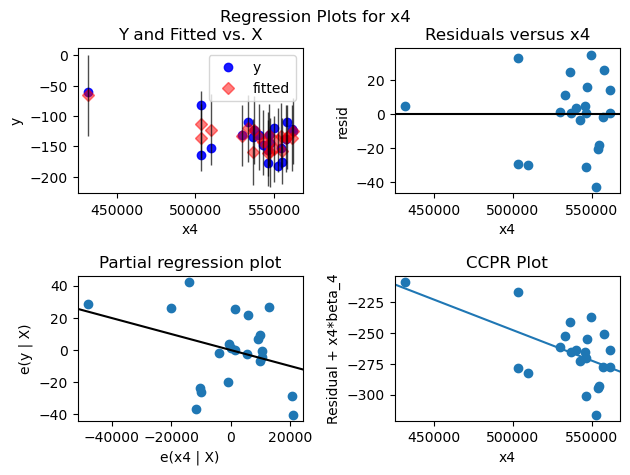

In [159]:
fig_after4 = sm.graphics.plot_regress_exog(multi_model_after, 4)

## Overall Model from 2000 to 2021

In [160]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     125.6
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           2.24e-34
Time:                        16:15:47   Log-Likelihood:                -413.59
No. Observations:                  88   AIC:                             837.2
Df Residuals:                      83   BIC:                             849.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -357.5624     63.749     -5.609      0.000    -484.356    -230.769
x1           128.8787     22.324      5.773      0.000      84.477     173.281
x2           -25.6351      2.246    -11.413      0.000     -30.103     -21.167
x3            -0.1903      0.024     -7.907      0.000      -0.238      -0.142
x4             0.0005      0.000      4.125      0.000       0.000       0.001
==============================================================================
Omnibus:                        4.590   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                3.849
Skew:                           0.435   Prob(JB):                        0.146
Kurtosis:                       3.540   Cond. No.                     1.09e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 7.170350405413925),
 ('p-value', 0.1271552007365637),
 ('f-value', 1.8407202265331164),
 ('f p-value', 0.1287576497108914)]

In [162]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,5)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

,VIF
UK_GDP,2.559339
EXUSUK,2.766826
Interest_Rate,2.478170
SMI,3.353548


eval_env: 1


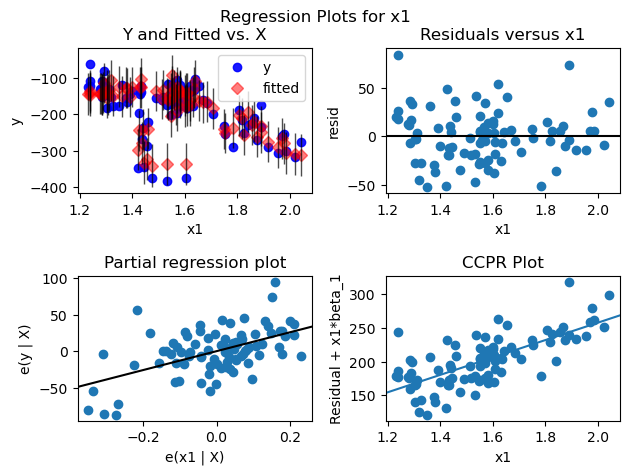

In [163]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

eval_env: 1


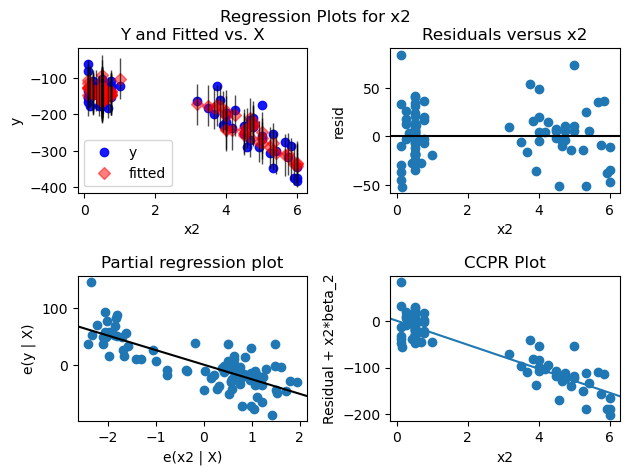

In [164]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

eval_env: 1


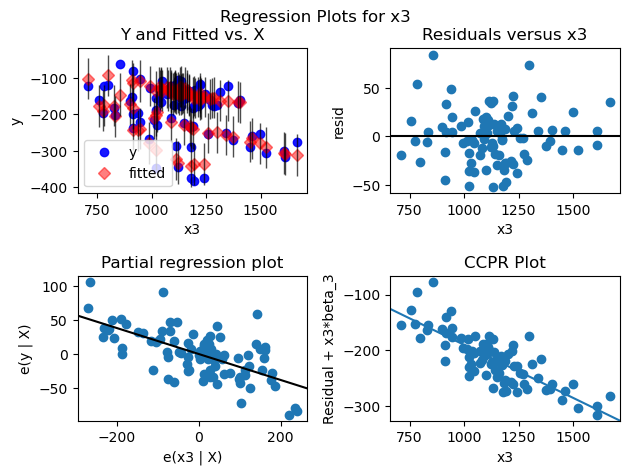

In [165]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

eval_env: 1


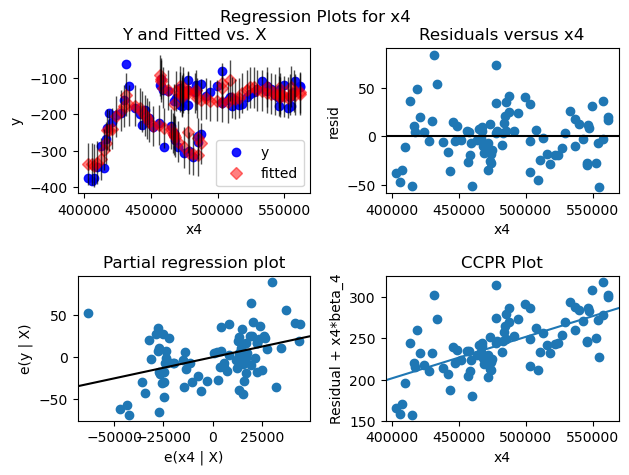

In [166]:
fig_overall4 = sm.graphics.plot_regress_exog(overall_model_ols, 4)